In [1]:
import pandas as pd
# get the csv file
# /media/Volume/data/MIT-BHI/data/

# read the csv file
df = pd.read_csv('/media/Volume/data/MIT-BHI/data/t_wave_split/labels_train.csv')
# get the first index where is_oversampled is True

idx = df[df['is_oversampled'] == True].index[8]
print(idx)

# get the dataframe from the idx to next 10 rows
df['len'] = df['hb_end'] - df['hb_start']
df['win_size'] = df['win_end'] - df['win_start']

# subtract the win_start from the previous win_start
df['win_start_diff'] = df['win_start'].diff()
df['hb_len'] = df['hb_end'] - df['hb_start']

df.head(n = 10)
# get hte maximum win size
max_win_size = df['win_size'].max()
print(max_win_size)

# get the row where the win_size is maximum
max_win_size_row = df[df['win_size'] == max_win_size]
print(max_win_size_row)

369
3724
       patient  sample_id orig_label label  hb_start  hb_end  r_peak  \
47754      208       2104          Q     Q    458221  458655  458621   

       is_oversampled  win_start  win_end  len  win_size  win_start_diff  \
47754            True     458221   461945  434      3724          1400.0   

       hb_len  
47754     434  


In [2]:
# get the row where the win_start_diff is mainimum
min_win_start_diff = df['win_size'].min()
print(min_win_start_diff)
# get row at index 61323
row = df.loc[4978]
print(row)

446
patient             108
sample_id             4
orig_label            N
label                 N
hb_start           1268
hb_end             1597
r_peak             1493
is_oversampled    False
win_start             0
win_end            3293
len                 329
win_size           3293
win_start_diff      0.0
hb_len              329
Name: 4978, dtype: object


In [3]:
# load the model from checkpoint
from models.xLSTM import myxLSTM
import torch

path = 'lightning_logs/version_112/checkpoints/epoch=9-step=4760.ckpt'
# path = 'lightning_logs/version_103/checkpoints/epoch=9-step=4760.ckpt'

xlstm = myxLSTM(patch_size=64, dropout=0.1, embedding_dim=64, activation_fn='leakyrelu', xlstm_depth=3)
state_dict = torch.load(path)['state_dict']
# Remove 'model.' prefix from keys
new_state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}
print(new_state_dict.keys())
xlstm.load_state_dict(new_state_dict)


flattened_size 6656
{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda-12.6/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-v

Using /home/luna97/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/luna97/.cache/torch_extensions/py311_cu124/slstm_HS64BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
/home/luna97/Research/MIT-BIH_ecg_arrhytmia/mit_bih_env/lib/python3.11/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS64BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module slstm_HS64BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/home/luna97/Research/MIT-BIH_ecg_arrhytmia/mit_bih_env/lib/python3.11/site-packages/xlstm/blocks/slstm/cell.py

ninja: no work to do.
dict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.3.weight', 'encoder.3.bias', 'encoder.6.weight', 'encoder.6.bias', 'down_project.weight', 'down_project.bias', 'xlstm.blocks.0.xlstm_norm.weight', 'xlstm.blocks.0.xlstm.learnable_skip', 'xlstm.blocks.0.xlstm.proj_up.weight', 'xlstm.blocks.0.xlstm.q_proj.weight', 'xlstm.blocks.0.xlstm.k_proj.weight', 'xlstm.blocks.0.xlstm.v_proj.weight', 'xlstm.blocks.0.xlstm.conv1d.conv.weight', 'xlstm.blocks.0.xlstm.conv1d.conv.bias', 'xlstm.blocks.0.xlstm.mlstm_cell.igate.weight', 'xlstm.blocks.0.xlstm.mlstm_cell.igate.bias', 'xlstm.blocks.0.xlstm.mlstm_cell.fgate.weight', 'xlstm.blocks.0.xlstm.mlstm_cell.fgate.bias', 'xlstm.blocks.0.xlstm.mlstm_cell.outnorm.weight', 'xlstm.blocks.0.xlstm.proj_down.weight', 'xlstm.blocks.1.xlstm_norm.weight', 'xlstm.blocks.1.xlstm.conv1d.conv.weight', 'xlstm.blocks.1.xlstm.conv1d.conv.bias', 'xlstm.blocks.1.xlstm.fgate.weight', 'xlstm.blocks.1.xlstm.igate.weight', 'xlstm.blocks.1.xlstm.zg

RuntimeError: Error(s) in loading state_dict for myxLSTM:
	Missing key(s) in state_dict: "sep_token", "encoder.2.weight", "encoder.2.bias", "encoder.4.weight", "encoder.4.bias", "encoder.8.weight", "encoder.8.bias", "encoder.10.weight", "encoder.10.bias". 
	Unexpected key(s) in state_dict: "rec.0.weight", "rec.0.bias", "rec.2.weight", "rec.2.bias", "rec.2.running_mean", "rec.2.running_var", "rec.2.num_batches_tracked", "rec.4.weight", "rec.4.bias", "encoder.3.weight", "encoder.3.bias". 
	size mismatch for encoder.0.weight: copying a param with shape torch.Size([32, 1, 3]) from checkpoint, the shape in current model is torch.Size([32, 1, 5]).
	size mismatch for encoder.6.weight: copying a param with shape torch.Size([128, 64, 3]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for encoder.6.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for down_project.weight: copying a param with shape torch.Size([64, 7424]) from checkpoint, the shape in current model is torch.Size([64, 6656]).

2
rec shape torch.Size([1, 56, 64])
sample shape torch.Size([3600, 1])
x shape torch.Size([1, 56, 1, 64])
shift_x shape torch.Size([56, 64])


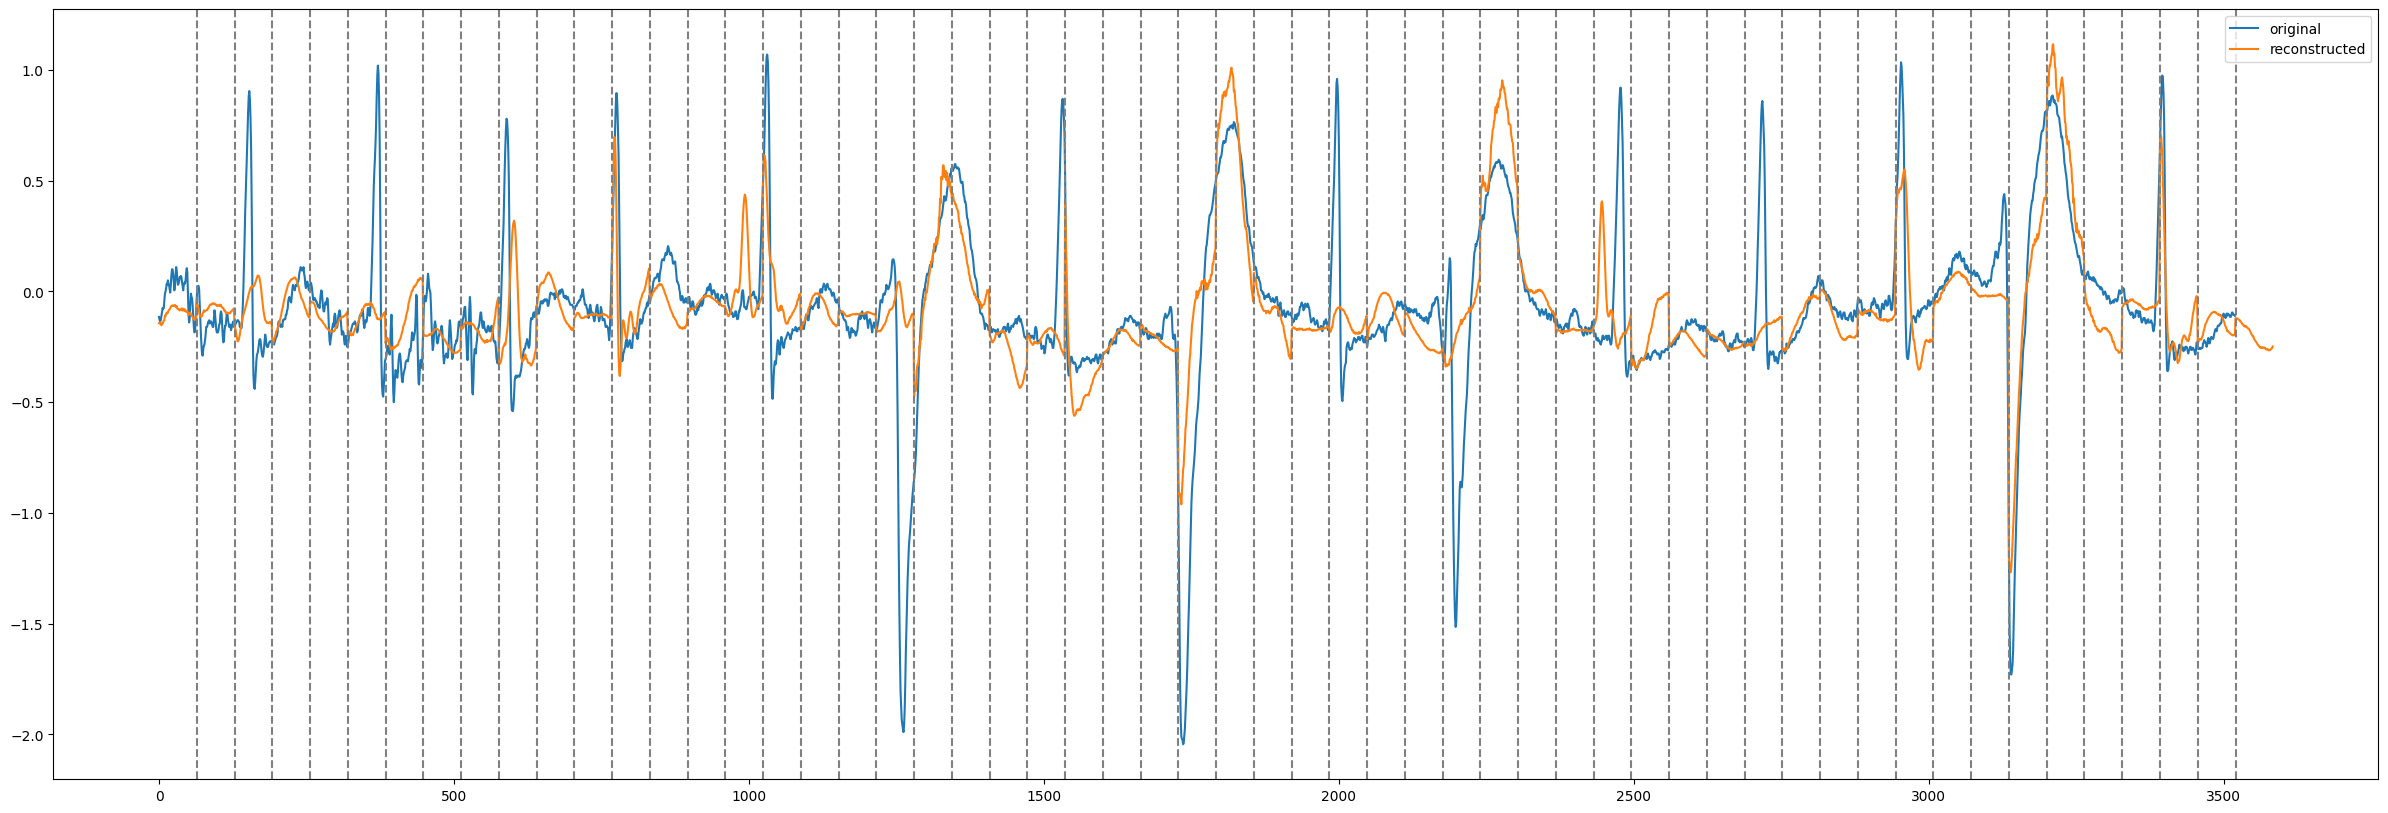

In [ ]:
# get one sample from the dataset
import numpy as np
from torch.utils.data import DataLoader

from dataset.mit_bih import ECGDataset, collate_fn
dataset = ECGDataset('/media/Volume/data/MIT-BHI/data/', subset='test', num_leads=1, oversample=False, random_shift=False, patch_size=64, normalize=False)

xlstm = xlstm.to('cuda')
xlstm.eval()
# get test dataset
sample = dataset[16799]
print(sample['label'])
sample = sample['window_signal'].to('cuda')

reconstruct = xlstm.reconstruct(sample) # [batch_size, seq_len // 64, patch_size]
print('rec shape', reconstruct.shape)
print('sample shape', sample.shape)
shift_reconstruct = reconstruct[:, :]
x, _, _ = xlstm.seq_to_token(sample)
shift_x = x.squeeze()
print('x shape', x.shape)
print('shift_x shape', shift_x.shape)

# try to reconstruct one element at a time
reconstruct = reconstruct.view(1, -1)
shift_x = shift_x.view(1, -1)

# plot the original and reconstructed signal
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 10))
plt.plot(shift_x[0, 64:].squeeze().cpu().numpy(), label='original')
plt.plot(reconstruct[0].squeeze().detach().cpu().numpy(), label='reconstructed')
# add a pipe avery 64 samples
for i in range(1, 3600 // 64):
    plt.axvline(x=64*i, color='gray', linestyle='--')
plt.legend()

# save the figure on disk
plt.savefig('figs/reconstructed_signal_normalized.png')


In [ ]:
x = xlstm.tokenize_signal(sample)
print(x.shape)
print(x)
print(x.flip(dims=(1, 2)).shape)
print(x.flip(dims=(1, 2)).flip(dims=(1, 2)))

torch.Size([1, 56, 64])
tensor([[[ 9.3062e-01,  1.4464e-01, -3.2447e-01,  ...,  9.8945e-02,
          -8.1626e-01, -1.5090e+00],
         [ 2.0820e+00,  5.0455e-01, -1.6357e-03,  ..., -1.0811e+00,
          -7.3148e-01, -1.5475e+00],
         [ 1.2560e+00,  1.0254e-01, -5.0278e-01,  ..., -6.0409e-01,
          -5.5216e-01, -1.1444e+00],
         ...,
         [-3.0943e-02, -4.0178e-01, -1.5636e+00,  ...,  7.3200e-01,
          -9.6250e-01, -3.4405e+00],
         [ 5.5366e-01,  2.7573e-01, -3.0558e-01,  ..., -3.6041e-01,
          -9.7518e-01, -2.2576e-01],
         [ 3.5299e-02, -5.8676e-02, -3.2418e-01,  ..., -2.5176e-01,
          -7.8428e-01, -1.6517e+00]]], device='cuda:0',
       grad_fn=<ViewBackward0>)
torch.Size([1, 56, 64])
tensor([[[ 9.3062e-01,  1.4464e-01, -3.2447e-01,  ...,  9.8945e-02,
          -8.1626e-01, -1.5090e+00],
         [ 2.0820e+00,  5.0455e-01, -1.6357e-03,  ..., -1.0811e+00,
          -7.3148e-01, -1.5475e+00],
         [ 1.2560e+00,  1.0254e-01, -5.0278e-01

loaded 345109 records
idx 0, signal shape (2919, 12), mean -0.009666666666666667, std [0.0681294  0.15196984 0.10253613 0.10596579 0.04248119 0.12518146
 0.17068444 0.16846165 0.40903167 0.54452346 0.29131199 0.17453331]
torch.Size([2919, 12])


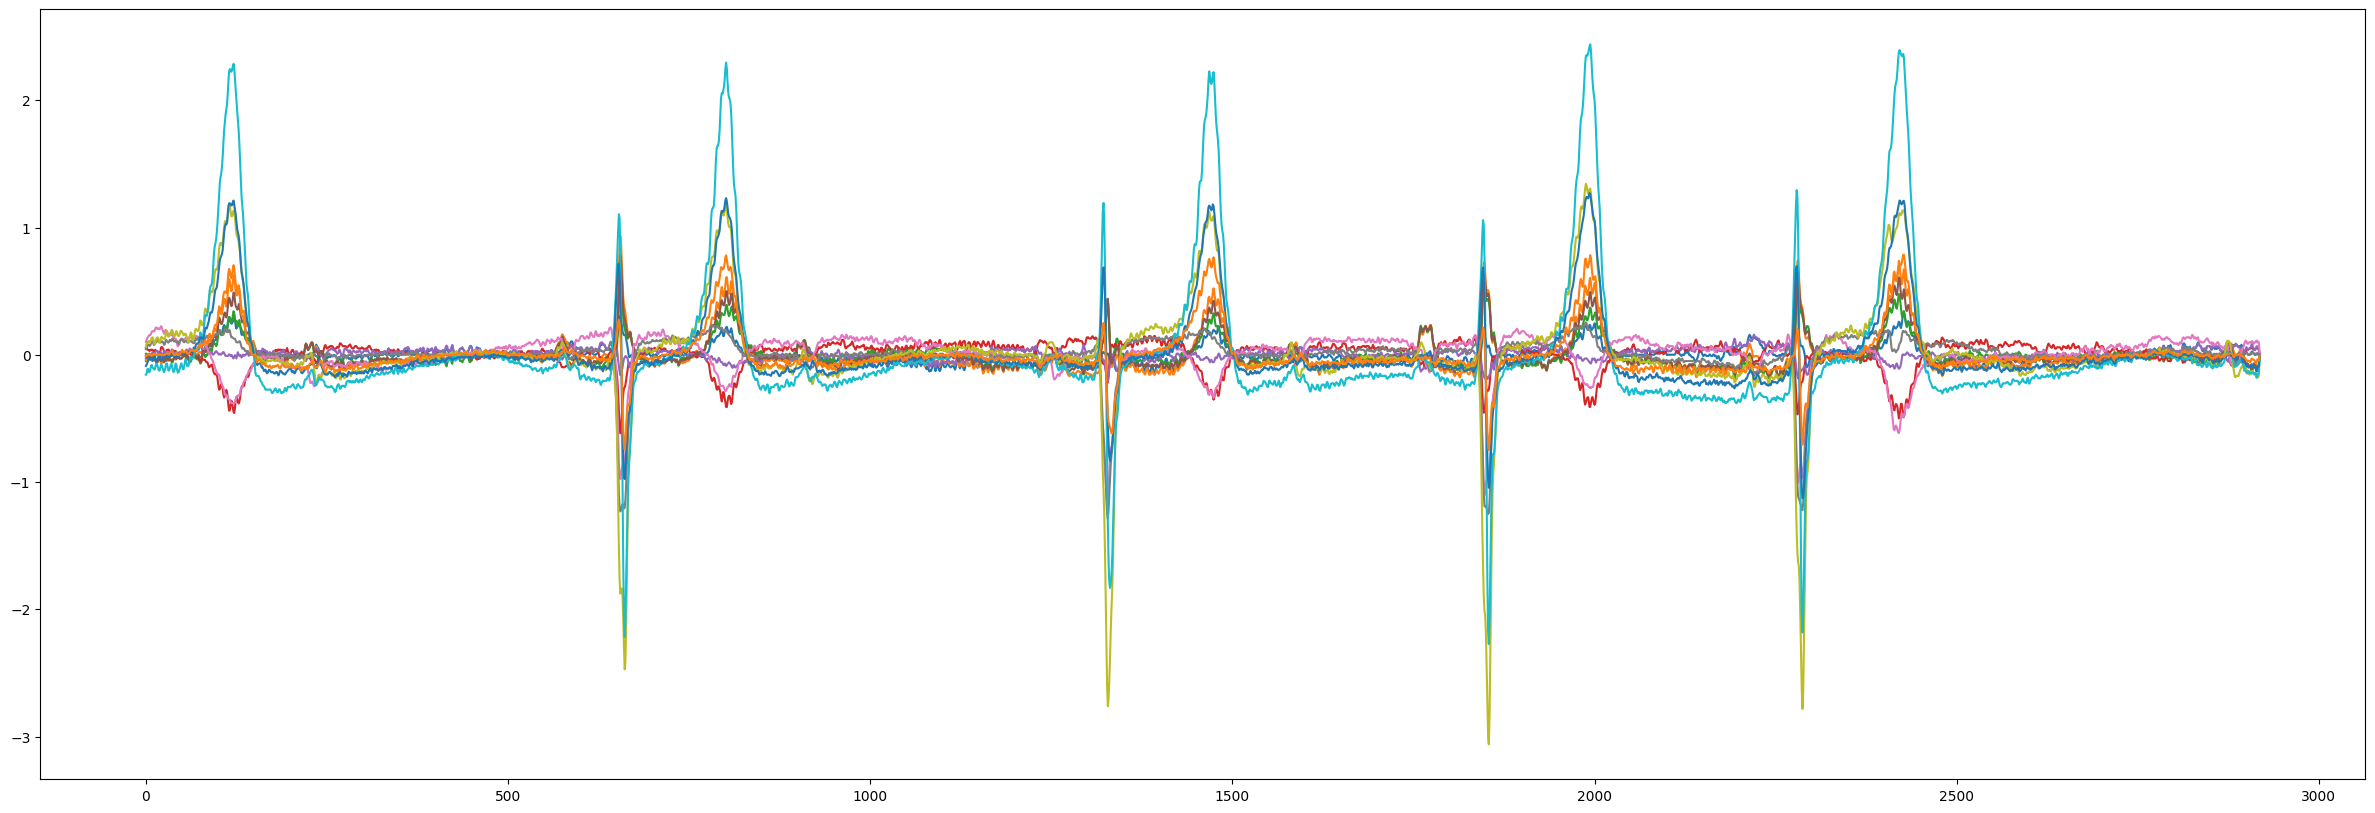

In [1]:
import dataset.code_15 as code_15
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt    

train_dataset = code_15.ECGCODE15Dataset('/media/Volume/data/CODE15/unlabeled_records', num_leads=12, random_shift=True, patch_size=64, normalize=False)

# plot the first sample

sample = train_dataset[0]
sample = sample['signal']
print(sample.shape)
plt.figure(figsize=(30, 10))
plt.plot(sample.squeeze().numpy())



loaded 345109 records
idx 9889, signal shape (3465, 12), mean 0.3712500000000001, std [0.34444098 0.41249039 0.22365072 0.36416064 0.20568441 0.28288711
 0.38333334 0.31999718 0.30272208 0.41389286 0.43179017 0.42579813]
torch.Size([3465])


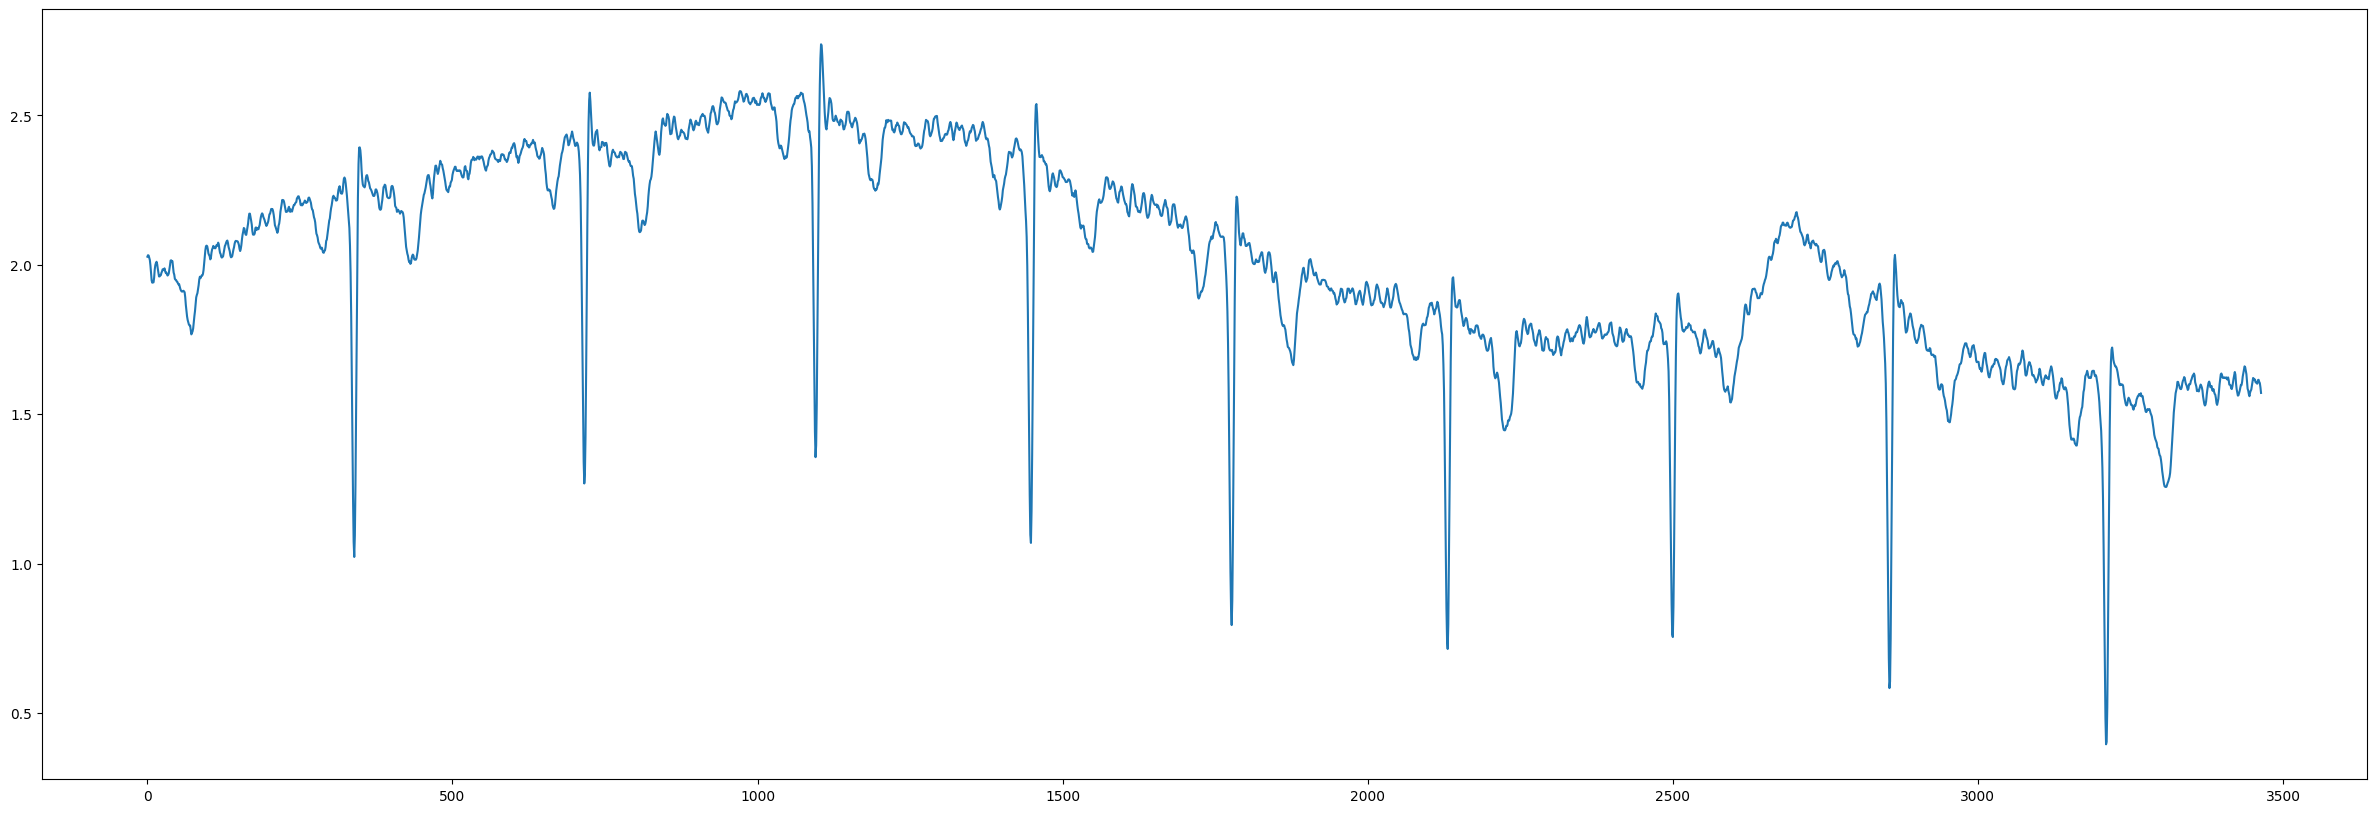

In [ ]:
from matplotlib import pyplot as plt    

train_dataset = code_15.ECGCODE15Dataset('/media/Volume/data/CODE15/unlabeled_records_360', num_leads=12, random_shift=True, patch_size=64, normalize=False)

# plot the first sample


idx 115859, signal shape (3676, 12), mean -2.5619166666666664, std [0.62415596 0.32148212 0.46992736 0.43681424 0.52854608 0.25321726
 0.62155149 0.41210071 0.56166376 0.61567948 0.47731861 0.49944271]
idx 23334, signal shape (3667, 12), mean -0.8223333333333334, std [0.44671128 0.20786061 0.45699168 0.26304151 0.43979083 0.27591146
 0.24443033 0.2705236  0.36595778 0.35283521 0.1792725  1.50302012]
idx 119857, signal shape (3224, 12), mean 0.9407500000000001, std [0.5175056  0.96328436 0.58628569 0.71601295 0.27246579 0.75268214
 0.68286483 0.63866518 0.69538763 0.87811089 0.81998417 0.75828248]
idx 247332, signal shape (3675, 12), mean -0.26399999999999985, std [1.38210626 0.69893657 1.23210093 0.90520755 1.26179684 0.72505093
 1.43458705 0.67611642 0.79199452 0.97061629 0.81671404 0.64537367]
idx 277575, signal shape (3523, 12), mean -0.7878333333333335, std [0.89320932 0.64680989 1.4212532  0.32169409 1.1422064  1.00972303
 0.57785869 0.58370106 0.57550127 0.58736743 1.05901078 0.6

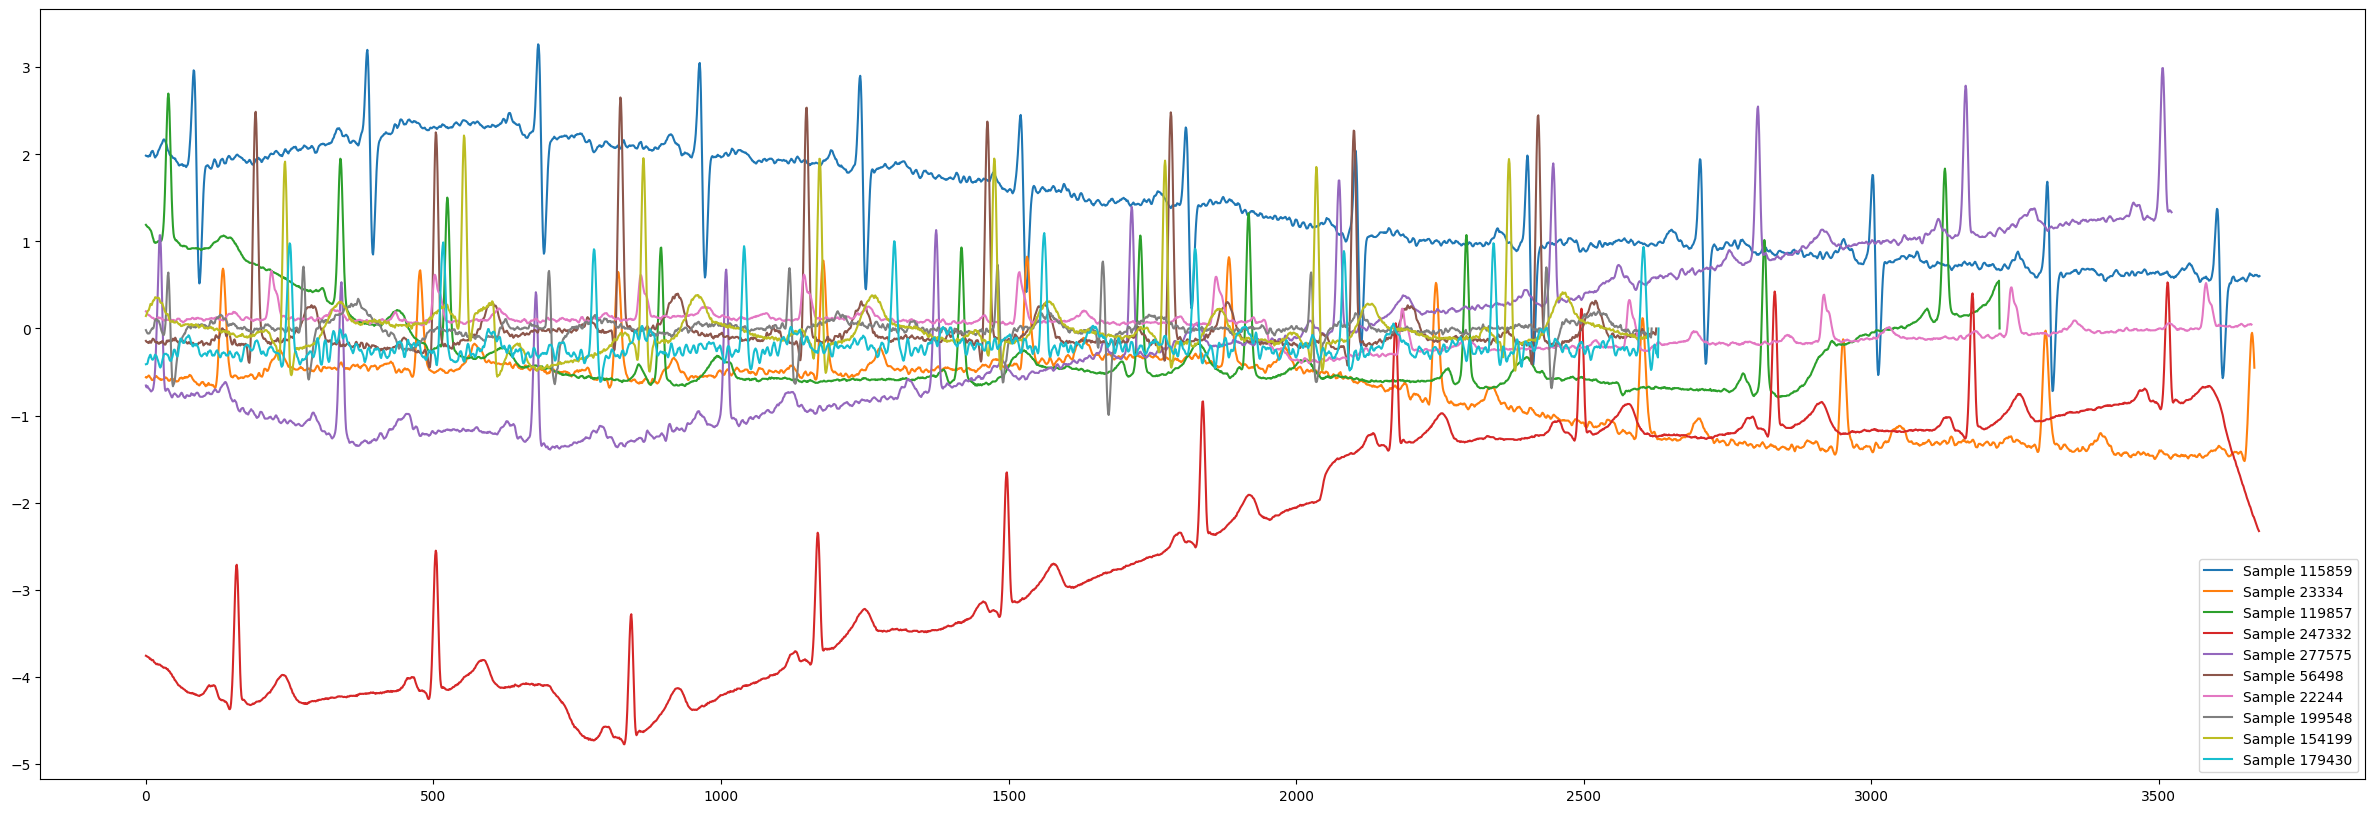

In [16]:
# print 10 random samples
import numpy as np
idxs = np.random.randint(0, len(train_dataset), 10)
plt.figure(figsize=(30, 10))
for idx in idxs:
    sample = train_dataset[idx]
    sample = sample['signal'][:, 0]
    plt.plot(sample.squeeze().numpy(), label=f'Sample {idx}')
plt.legend()
